# 6.7. GPUs

__OBSERVAÇÃO: 
JUPYTER NOTEBOOK NÃO POSSUI GPU, APENAS GOOGLE COLAB. (INSTALEI POSTERIORMENTE NO PYTORCH, AGORA TEM!!!)

VISUALIZAR EM:__
https://colab.research.google.com/drive/1zVgXdPO94lWG1nRGC5L3VGDYOCx26Df1#scrollTo=KLId2fz35r5P

Instalando GPU para utilização no torch: 

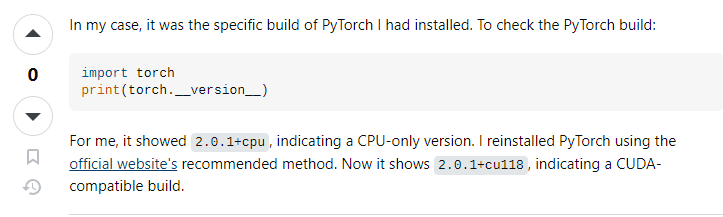

https://stackoverflow.com/questions/65439154/pytorch-doesnt-work-with-cuda-in-pycharm-intellij

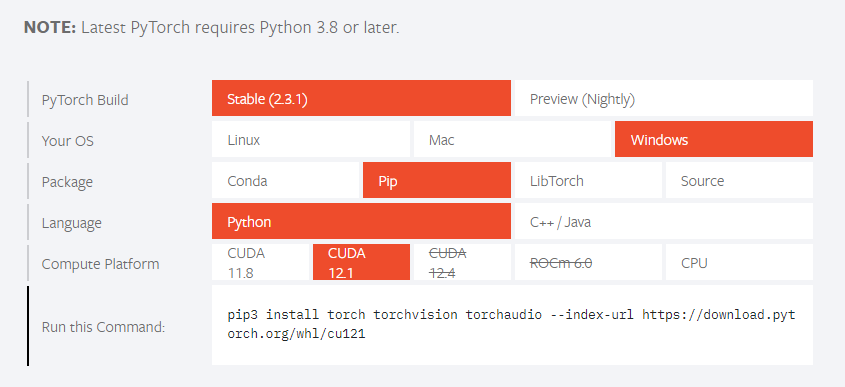

https://pytorch.org/


# GPU - Graphics Processing Unit, ou Unidade de Processamento Gráfico.

Nesta seção, começamos a discutir como aproveitar esse desempenho computacional para sua pesquisa. Primeiro usando uma única GPU e, mais tarde, como usar várias GPUs e vários servidores (com várias GPUs).

Especificamente, discutiremos como usar uma única GPU NVIDIA para cálculos. Primeiro, certifique-se de ter pelo menos uma GPU NVIDIA instalada. Em seguida, baixe o driver NVIDIA e o CUDA e siga os prompts para definir o caminho apropriado. Depois que essas preparações forem concluídas, o nvidia-smicomando pode ser usado para visualizar as informações da placa de vídeo.

No PyTorch, cada array tem um dispositivo; frequentemente nos referimos a ele como um contexto . Até agora, por padrão, todas as variáveis ​​e computação associada foram atribuídas à CPU. 

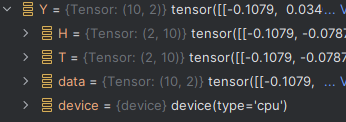

Normalmente, outros contextos podem ser várias GPUs. As coisas podem ficar ainda mais complicadas quando implantamos trabalhos em vários servidores.

Para executar os programas nesta seção, você precisa de pelo menos duas GPUs. Observe que isso pode ser extravagante para a maioria dos computadores desktop, mas está facilmente disponível na nuvem, por exemplo, usando as instâncias multi-GPU do AWS EC2. Quase todas as outras seções não exigem várias GPUs, mas aqui queremos simplesmente ilustrar o fluxo de dados entre diferentes dispositivos.

In [9]:
import torch
from torch import nn
from d2l import torch as d2l

# 6.7.1. Dispositivos de computação

No PyTorch, a CPU e a GPU podem ser indicadas por torch.device('cpu') e torch.device('cuda').

Deve-se notar que o cpudispositivo significa todas as CPUs físicas e memória. Isso significa que os cálculos do PyTorch tentarão usar todos os núcleos da CPU.

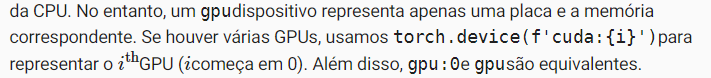

In [10]:
def cpu():  #@save
    """Get the CPU device."""
    return torch.device('cpu')

def gpu(i=0):  #@save
    """Get a GPU device."""
    return torch.device(f'cuda:{i}')

cpu(), gpu(), gpu(1)

(device(type='cpu'),
 device(type='cuda', index=0),
 device(type='cuda', index=1))

In [11]:
def num_gpus():  #@save
    """Get the number of available GPUs."""
    return torch.cuda.device_count()

num_gpus()

1

In [13]:
torch.cuda.is_available()

True

In [14]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce MX130'

No Google Colab é possível utilizar GPU gratuitamente.

https://colab.research.google.com/drive/1zVgXdPO94lWG1nRGC5L3VGDYOCx26Df1#scrollTo=KLId2fz35r5P

https://medium.com/@romxzg/maximizing-computing-power-a-guide-to-google-colab-hardware-options-a68469415291#:~:text=Hardware%20accelerators%2C%20in%20the%20context,simulations%2C%20and%20processing%20large%20datasets.

Agora definimos duas funções convenientes que nos permitem executar código mesmo que as GPUs solicitadas não existam.

In [16]:
def try_gpu(i=0):  #@save
    """Return gpu(i) if exists, otherwise return cpu()."""
    if num_gpus() >= i + 1:
        return gpu(i)
    return cpu()

def try_all_gpus():  #@save
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    return [gpu(i) for i in range(num_gpus())]

try_gpu(), try_gpu(10), try_all_gpus()

(device(type='cuda', index=0),
 device(type='cpu'),
 [device(type='cuda', index=0)])

# 6.7.2. Tensores e GPUs

Por padrão, tensores são criados na CPU. Podemos consultar o dispositivo onde o tensor está localizado.

In [17]:
x = torch.tensor([1, 2, 3])
x.device

device(type='cpu')

É importante notar que sempre que queremos operar em vários termos, eles precisam estar no mesmo dispositivo. Por exemplo, se somarmos dois tensores, precisamos garantir que ambos os argumentos estejam no mesmo dispositivo — caso contrário, o framework não saberia onde armazenar o resultado ou mesmo como decidir onde executar a computação.

# 6.7.2.1. Armazenamento na GPU

Existem várias maneiras de armazenar um tensor na GPU.
Em geral, precisamos ter certeza de que não criamos dados que excedam o limite de memória da GPU.




In [18]:
X = torch.ones(2, 3, device=try_gpu())
X

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')

In [19]:
X1 = torch.ones(2, 3, device = 'cuda')
X1

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')

Supondo que você tenha pelo menos duas GPUs, o código a seguir criará um tensor aleatório, Y, na segunda GPU.

In [20]:
Y = torch.rand(2, 3, device=try_gpu(1))
Y

tensor([[0.7592, 0.2134, 0.7964],
        [0.3777, 0.9487, 0.7179]])

In [21]:
Y0 = torch.rand(2, 3, device=try_gpu(0))   # Tenho apenas 1 gpu = 'cuda0'
Y0

tensor([[0.4467, 0.2756, 0.8032],
        [0.4131, 0.8325, 0.6465]], device='cuda:0')

# 6.7.2.2. Cópia

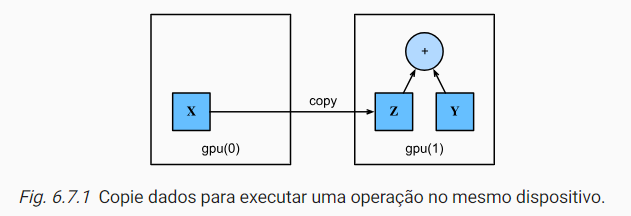

In [22]:
Z = X.cuda(1)
print(X)
print(Z)

# Agora que os dados (Z e Y) estão na mesma GPU, podemos somá-los.

RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [23]:
Z = X.cpu()   # como não tenho outra gpu utilizarei na cpu
print(X)
print(Z)
print(Z.device)
print(Y)

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')
tensor([[1., 1., 1.],
        [1., 1., 1.]])
cpu
tensor([[0.7592, 0.2134, 0.7964],
        [0.3777, 0.9487, 0.7179]])


In [24]:
Y + Z

tensor([[1.7592, 1.2134, 1.7964],
        [1.3777, 1.9487, 1.7179]])

Mas e se sua variável Zjá estivesse na sua segunda GPU? O que acontece se ainda chamarmos Z.cuda(1)? Ela retornará Zem vez de fazer uma cópia e alocar nova memória.

In [25]:
Z.cuda(1) is Z

RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [26]:
! conda install numba

'conda' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


# 6.7.2.3. Notas laterais

As pessoas usam GPUs para fazer aprendizado de máquina porque esperam que elas sejam rápidas. Mas transferir variáveis entre dispositivos é lento: muito mais lento do que computação. Então, queremos que você tenha 100% de certeza de que quer fazer algo lento antes de deixarmos você fazer. Se a estrutura de aprendizado profundo apenas fizesse a cópia automaticamente sem travar, você pode não perceber que escreveu algum código lento.

Transferir dados não é apenas lento, mas também torna a paralelização muito mais difícil, já que temos que esperar que os dados sejam enviados (ou melhor, recebidos) antes de podermos prosseguir com mais operações. É por isso que as operações de cópia devem ser tomadas com muito cuidado. Como regra geral, muitas operações pequenas são muito piores do que uma operação grande. Além disso, várias operações ao mesmo tempo são muito melhores do que muitas operações únicas intercaladas no código, a menos que você saiba o que está fazendo.

# 6.7.3. Redes neurais e GPUs

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [6]:
def num_gpus():  #@save
    """Get the number of available GPUs."""
    return torch.cuda.device_count()

def gpu(i=0):  #@save
    """Get a GPU device."""
    return torch.device(f'cuda:{i}')

def cpu():  #@save
    """Get the CPU device."""
    return torch.device('cpu')

def try_gpu(i=0):  #@save
    """Return gpu(i) if exists, otherwise return cpu()."""
    if num_gpus() >= i + 1:
        return gpu(i)
    return cpu()


def try_all_gpus():                                                     # Para o caso de mais de uma GPU
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    return [gpu(i) for i in range(num_gpus())]

In [7]:
num_gpus()

1

In [8]:
try_gpu(0)

device(type='cuda', index=0)

In [12]:
torch.cuda.is_available()

True

In [15]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce MX130'

In [28]:
try_all_gpus()

[device(type='cuda', index=0)]

O código a seguir coloca os parâmetros do modelo na GPU.

In [27]:
net = nn.Sequential(nn.LazyLinear(1))
net = net.to(device=try_gpu())

Quando a entrada é um tensor na GPU, o modelo calculará o resultado na mesma GPU.

In [30]:
X = torch.ones(2, 3, device=try_gpu())
X

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')

In [31]:
net(X)

tensor([[1.0499],
        [1.0499]], device='cuda:0', grad_fn=<AddmmBackward0>)

Vamos confirmar se os parâmetros do modelo estão armazenados na mesma GPU.

In [32]:
net[0].weight.data.device

device(type='cuda', index=0)

Para o treinador suportar GPU utilize os decorators:

In [33]:
@d2l.add_to_class(d2l.Trainer)  #@save
def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
    self.save_hyperparameters()
    self.gpus = [d2l.gpu(i) for i in range(min(num_gpus, d2l.num_gpus()))]

@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    if self.gpus:
        batch = [a.to(self.gpus[0]) for a in batch]
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_model(self, model):
    model.trainer = self
    model.board.xlim = [0, self.max_epochs]
    if self.gpus:
        model.to(self.gpus[0])
    self.model = model

# Código Agrupado:

In [34]:
import torch
from torch import nn
from d2l import torch as d2l

# -----------------------------------------------------------------------------------
def num_gpus():  #@save
    """Get the number of available GPUs."""
    return torch.cuda.device_count()

def gpu(i=0):  #@save
    """Get a GPU device."""
    return torch.device(f'cuda:{i}')

def cpu():  #@save
    """Get the CPU device."""
    return torch.device('cpu')

def try_gpu(i=0):  #@save
    """Return gpu(i) if exists, otherwise return cpu()."""
    if num_gpus() >= i + 1:
        return gpu(i)
    return cpu()


def try_all_gpus():                                                     # Para o caso de mais de uma GPU
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    return [gpu(i) for i in range(num_gpus())]


# -----------------------------------------------------------------------------------
# Para o treinador suportar GPU utilize os decorators:

@d2l.add_to_class(d2l.Trainer)  #@save
def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
    self.save_hyperparameters()
    self.gpus = [d2l.gpu(i) for i in range(min(num_gpus, d2l.num_gpus()))]

@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    if self.gpus:
        batch = [a.to(self.gpus[0]) for a in batch]
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_model(self, model):
    model.trainer = self
    model.board.xlim = [0, self.max_epochs]
    if self.gpus:
        model.to(self.gpus[0])
    self.model = model

# -----------------------------------------------------------------------------------
print(f'Quantidade de GPUs: {num_gpus()}')
print(f'Cuda disponível?: {torch.cuda.is_available()}')
print(f'Todas as GPUs disponíveis: {try_all_gpus()}')
print(f'Device: {try_gpu(0)}')
print(f'Nome da GPU/Placa de vídeo: {torch.cuda.get_device_name(0)}')

# -----------------------------------------------------------------------------------
X = torch.ones(2, 3, device=try_gpu())  # Quando a entrada é um tensor na GPU, o modelo calculará o resultado na mesma GPU.

net = nn.Sequential(nn.LazyLinear(1))
net = net.to(device=try_gpu())        # coloca os parâmetros do modelo na GPU. Modo alternativo: net = net.to(device = 'cuda')
net(X)


net[0].weight.data.device    #  confirmar se os parâmetros do modelo estão armazenados na mesma GPU


Quantidade de GPUs: 1
Cuda disponível?: True
Todas as GPUs disponíveis: [device(type='cuda', index=0)]
Device: cuda:0
Nome da GPU/Placa de vídeo: NVIDIA GeForce MX130


device(type='cuda', index=0)

# 6.7.4. Resumo

Podemos especificar dispositivos para armazenamento e cálculo, como a CPU ou GPU. Por padrão, os dados são criados na memória principal e, em seguida, usam a CPU para cálculos. A estrutura de aprendizado profundo requer que todos os dados de entrada para cálculo estejam no mesmo dispositivo, seja CPU ou a mesma GPU. Você pode perder desempenho significativo movendo dados sem cuidado. Um erro típico é o seguinte: calcular a perda para cada minibatch na GPU e relatá-la de volta ao usuário na linha de comando (ou registrá-la em um NumPy ndarray) acionará um bloqueio global do interpretador que paralisa todas as GPUs. É muito melhor alocar memória para registro dentro da GPU e mover apenas registros maiores.

# Referências

https://stackoverflow.com/questions/65439154/pytorch-doesnt-work-with-cuda-in-pycharm-intellij

https://pytorch.org/

https://www.youtube.com/watch?v=r7Am-ZGMef8 \
Links used: \
Visual Studio 2019: https://visualstudio.microsoft.com/vs... \
NVIDIA CUDA: https://developer.nvidia.com/cuda-too... \
NVIDIA CUDNN:  https://developer.nvidia.com/rdp/cudn... \
PyTorch : https://pytorch.org/get-started/locally/




# Adaptações para utilizar com o dataset FashionMNIST


In [35]:
import torch
from torch import nn
from d2l import torch as d2l
import time
# -----------------------------------------------------------------------------------

# -----------------------------------------------------------------------------------
# Funções de apoio para utilizar GPU:
def num_gpus():  #@save
    """Get the number of available GPUs."""
    return torch.cuda.device_count()

def gpu(i=0):  #@save
    """Get a GPU device."""
    return torch.device(f'cuda:{i}')

def cpu():  #@save
    """Get the CPU device."""
    return torch.device('cpu')

def try_gpu(i=0):  #@save
    """Return gpu(i) if exists, otherwise return cpu()."""
    if num_gpus() >= i + 1:
        return gpu(i)
    return cpu()

def try_all_gpus():                                                     # Para o caso de mais de uma GPU
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    return [gpu(i) for i in range(num_gpus())]
# -----------------------------------------------------------------------------------

# -----------------------------------------------------------------------------------
# Para o treinador suportar GPU utilize os decorators:
@d2l.add_to_class(d2l.Trainer)  #@save
def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
    self.save_hyperparameters()
    self.gpus = [d2l.gpu(i) for i in range(min(num_gpus, d2l.num_gpus()))]

@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    if self.gpus:
        batch = [a.to(self.gpus[0]) for a in batch]
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_model(self, model):
    model.trainer = self
    model.board.xlim = [0, self.max_epochs]
    if self.gpus:
        model.to(self.gpus[0])
    self.model = model
# -----------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)
# -----------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------
# Modelo MLP:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), #reshape:(28 x 28) para (1 x 784) # Flatten = Achatar. Equivalente a: X=X.reshape((-1, self.num_inputs))
                                 nn.LazyLinear(out_features = num_hiddens), # camada escondida. Ainda é Linear.
                                                                            # LazyLinear(linear preguiçosa=sem parâmetros de entrada, apenas de saída.)
                                 nn.ReLU(),                    # função de ativação. Converte a função em não Linear.
                                 nn.LazyLinear(out_features = num_outputs))   # camada de saída
# ------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------
# 5.2.2.2. Treinamento
# O ciclo de treinamento é exatamente o mesmo de quando implementamos a regressão softmax.
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)   # lr é o learning rate
model = model.to(device=try_gpu())        # coloca os parâmetros do modelo na GPU. Modo alternativo: net = net.to(device = 'cuda')
# ------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------
# Passando todos os dados de FashionMNIST para GPU:
data = d2l.FashionMNIST(batch_size=256)      # originalmente na GPU
data_train2 = data.train.data.cuda(0)        # cópia dos dados usando GPU
data_val2 = data.val.data.cuda(0)            # cópia dos dados usando GPU

data.train.data = data_train2                # substituindo os dados da cpu para dados que estão na gpu
data.val.data = data_val2                    # substituindo os dados da cpu para dados que estão na gpu
# ------------------------------------------------------------------------------------
targets_train2 = data.train.data.cuda(0)
data.train.targets = targets_train2

targets_val2 = data.val.data.cuda(0)
data.val.targets = targets_val2
# ------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------
# Treinamento:
trainer = d2l.Trainer(max_epochs=3)

tempo_inicial = time.time()
trainer.fit(model, data)
tempo_final = time.time()

tempo_gasto = tempo_final - tempo_inicial
# # ------------------------------------------------------------------------------------


y_hat = model(data.val.data.type(torch.float32))
print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')

ValueError: only one element tensors can be converted to Python scalars

# 6.7.5. Exercícios

# Ex.1 - Tente uma tarefa de computação maior, como a multiplicação de matrizes grandes, e veja a diferença de velocidade entre a CPU e a GPU. E quanto a uma tarefa com um pequeno número de cálculos?

In [36]:
import torch
from torch import nn
from d2l import torch as d2l
import time

# ----------------------------------------------------------------------------
# x1 = torch.tensor([[1,2],[3,4]])
# y1 = torch.tensor([[2,4],[1,3]])
# z1 = torch.matmul(x1,y1)

# ----------------------------------------------------------------------------
x = torch.rand(10000,10000)
y = torch.randn(10000,10000)   # normal distribution

tempo_inicial = time.time()
z = torch.matmul(x,y)
tempo_final = time.time()

tempo_gasto_cpu = tempo_final - tempo_inicial
# ----------------------------------------------------------------------------

# ----------------------------------------------------------------------------
x1 = x.cuda(0)
y1 = y.cuda(0)

tempo_inicial_gpu = time.time()
z1 = torch.matmul(x1,y1)
tempo_final_gpu = time.time()

tempo_gasto_gpu = tempo_final_gpu - tempo_inicial_gpu
# ----------------------------------------------------------------------------

print(f'CPU: {tempo_gasto_cpu}')
print(f'GPU: {tempo_gasto_gpu}')

CPU: 9.066549301147461
GPU: 0.008347749710083008


In [37]:
z[0][0]

tensor(68.1992)

In [38]:
z1[0][0]

RuntimeError: CUDA error: the launch timed out and was terminated
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Ao tentar acessar os dados na GPU ocorre o seguinte erro:

RuntimeError: CUDA error: the launch timed out and was terminated
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Este alerta que 'a inicialização expirou e foi encerrada'. Provavelmente isto ocorre devido ao estouro de capacidade da GPU, pois utilizamos dados muito grandes. Quando utilizamos dados menores isto não ocorre.

# Ex. 2 - Como devemos ler e escrever parâmetros do modelo na GPU?

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# -----------------------------------------------------------------------------------
def num_gpus():  #@save
    """Get the number of available GPUs."""
    return torch.cuda.device_count()

def gpu(i=0):  #@save
    """Get a GPU device."""
    return torch.device(f'cuda:{i}')

def cpu():  #@save
    """Get the CPU device."""
    return torch.device('cpu')

def try_gpu(i=0):  #@save
    """Return gpu(i) if exists, otherwise return cpu()."""
    if num_gpus() >= i + 1:
        return gpu(i)
    return cpu()


def try_all_gpus():                                                     # Para o caso de mais de uma GPU
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    return [gpu(i) for i in range(num_gpus())]


# -----------------------------------------------------------------------------------
# Para o treinador suportar GPU utilize os decorators:

@d2l.add_to_class(d2l.Trainer)  #@save
def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
    self.save_hyperparameters()
    self.gpus = [d2l.gpu(i) for i in range(min(num_gpus, d2l.num_gpus()))]

@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    if self.gpus:
        batch = [a.to(self.gpus[0]) for a in batch]
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_model(self, model):
    model.trainer = self
    model.board.xlim = [0, self.max_epochs]
    if self.gpus:
        model.to(self.gpus[0])
    self.model = model

# -----------------------------------------------------------------------------------
print(f'Quantidade de GPUs: {num_gpus()}')
print(f'Cuda disponível?: {torch.cuda.is_available()}')
print(f'Todas as GPUs disponíveis: {try_all_gpus()}')
print(f'Device: {try_gpu(0)}')
print(f'Nome da GPU/Placa de vídeo: {torch.cuda.get_device_name(0)}')

# -----------------------------------------------------------------------------------



Quantidade de GPUs: 1
Cuda disponível?: True
Todas as GPUs disponíveis: [device(type='cuda', index=0)]
Device: cuda:0
Nome da GPU/Placa de vídeo: NVIDIA GeForce MX130


C:\Users\zeh\pythonProject\.venv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


device(type='cuda', index=0)

In [2]:
X = torch.ones(2, 3, device=try_gpu())  # Quando a entrada é um tensor na GPU, o modelo calculará o resultado na mesma GPU.

net = nn.Sequential(nn.LazyLinear(1))
net = net.to(device=try_gpu())        # coloca os parâmetros do modelo na GPU. Modo alternativo: net = net.to(device = 'cuda')
net(X)


net[0].weight.data.device    #  confirmar se os parâmetros do modelo estão armazenados na mesma GPU

device(type='cuda', index=0)

# Ex. 3 - Meça o tempo necessário para calcular 1000 multiplicações de matriz-matriz de 100x100 matrizes e registrar a norma de Frobenius da matriz de saída, um resultado de cada vez. Compare isso com manter um registro na GPU e transferir apenas o resultado final.

<!-- 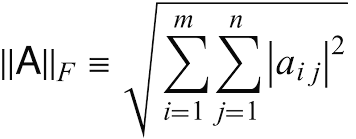 -->


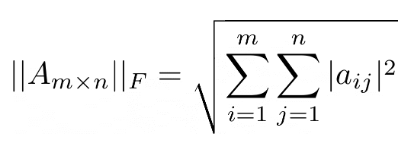


In [4]:
import torch
import time

# # ------------------------------------------------------------------------------
# # Numpy:
# import numpy as np
# from numpy import linalg
#
# vector = np.arange(1,7)
# print(vector)
#
# matrix = vector.reshape(2,3)
# print(matrix)
#
# frob_norm = linalg.norm(matrix,ord='fro')    # norma de Frobenius
# print(f"{frob_norm = :.2f}")
# # ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------
# Can you use NumPy on GPU?
# Since NumPy only supports CPU, it can only convert objects whose data exists on the CPU. But other libraries, like PyTorch and CuPy, may exchange data on GPU using this protocol.
# ------------------------------------------------------------------------------------------------------------

# # ------------------------------------------------------------------------------
# # Tensor:
# Numpy não trabalha com GPU,apenas com CPU. Deve-se usar torch.
# vector1 = torch.arange(1.0,7.0)   # deve-se usar ponto flutuante. Com inteiro dá erro.
# print(vector1)
#
# matrix1 = vector1.reshape(2,3)
# print(matrix1)
#
# frob_norm = torch.norm(matrix1, p='fro', dim=None, keepdim=False, out=None, dtype=None)   # norma de Frobenius
# print(f"{frob_norm = :.2f}")
# # ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# CPU:
lista = []
for i in range(0,1000):                   # cria lista com 1000 matrizes aleatórias 100x100.
    x = torch.rand(100,100)
    lista.append(x)

tempo_inicial_cpu = time.time()
mult = torch.matmul(lista[0], lista[1])  # inicializa 'mult' multiplicando as 2 primeiras matrizes
frob_norm = torch.norm(mult, p='fro', dim=None, keepdim=False, out=None, dtype=None)  # norma de Frobenius da primeira matriz de saída
frob = [frob_norm]

for i in range(2,1000):
    mult = torch.matmul(mult, lista[i])           # multiplica as 1000 matrizes criadas.
    frob_norm = torch.norm(mult, p='fro', dim=None, keepdim=False, out=None, dtype=None)      # calcula a norma de Frobenius
    frob.append(frob_norm)                        # guarda a norma de Frobenius em uma lista

print(f'{frob[-1] = :.2f}')                       # última norma de Frobenius calculada

tempo_final_cpu = time.time()
tempo_gasto_cpu = tempo_final_cpu - tempo_inicial_cpu
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# GPU:
lista1 = [lista[0].cuda(0)]      # inicializa a lista com o primeiro vetor da lista anterior, entretanto, na gpu.
for i in range(1,1000):
    x1 = lista[i].cuda(0)        # passa todos os vetores criados anteriormente para a gpu.
    lista1.append(x1)

tempo_inicial_gpu = time.time()
mult1 = torch.matmul(lista1[0], lista1[1])  # inicializa 'mult' multiplicando as 2 primeiras matrizes.
frob_norm1 = torch.norm(mult1, p='fro', dim=None, keepdim=False, out=None, dtype=None)  # norma de Frobenius da primeira matriz de saída.
frob1 = [frob_norm1]                        # inicializa o vetor com normas de Frobenius.

for i in range(2,1000):
    mult1 = torch.matmul(mult1, lista1[i])         # multiplica as 1000 matrizes criadas.
    frob_norm1 = torch.norm(mult1, p='fro', dim=None, keepdim=False, out=None, dtype=None)     # calcula a norma de Frobenius
    frob1.append(frob_norm1)                        # guarda a norma de Frobenius em uma lista

print(f'{frob1[-1] = :.2f}')                       # última norma de Frobenius calculada

tempo_final_gpu = time.time()
tempo_gasto_gpu = tempo_final_gpu - tempo_inicial_gpu
# ------------------------------------------------------------------------------

print(f'CPU: {tempo_gasto_cpu}')
print(f'GPU: {tempo_gasto_gpu}')

frob[-1] = nan
frob1[-1] = nan
CPU: 0.035904645919799805
GPU: 0.13045668601989746


Para este caso em específico a CPU foi mais rápida. 

Se utilizarmos matrizes maiores, por exemplo 1000x1000, e diminuirmos a quantidade de matrizes para 100 para não estourar a memória da GPU, temos um caso em que a GPU é mais rápida. 

In [5]:
import torch
import time

# # ------------------------------------------------------------------------------
# # Numpy:
# import numpy as np
# from numpy import linalg
#
# vector = np.arange(1,7)
# print(vector)
#
# matrix = vector.reshape(2,3)
# print(matrix)
#
# frob_norm = linalg.norm(matrix,ord='fro')    # norma de Frobenius
# print(f"{frob_norm = :.2f}")
# # ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------
# Can you use NumPy on GPU?
# Since NumPy only supports CPU, it can only convert objects whose data exists on the CPU. But other libraries, like PyTorch and CuPy, may exchange data on GPU using this protocol.
# ------------------------------------------------------------------------------------------------------------

# # ------------------------------------------------------------------------------
# # Tensor:
# Numpy não trabalha com GPU,apenas com CPU. Deve-se usar torch.
# vector1 = torch.arange(1.0,7.0)   # deve-se usar ponto flutuante. Com inteiro dá erro.
# print(vector1)
#
# matrix1 = vector1.reshape(2,3)
# print(matrix1)
#
# frob_norm = torch.norm(matrix1, p='fro', dim=None, keepdim=False, out=None, dtype=None)   # norma de Frobenius
# print(f"{frob_norm = :.2f}")
# # ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# CPU:
lista = []
for i in range(0,100):                   # cria lista com 1000 matrizes aleatórias 100x100.
    x = torch.rand(1000,1000)
    lista.append(x)

tempo_inicial_cpu = time.time()
mult = torch.matmul(lista[0], lista[1])  # inicializa 'mult' multiplicando as 2 primeiras matrizes
frob_norm = torch.norm(mult, p='fro', dim=None, keepdim=False, out=None, dtype=None)  # norma de Frobenius da primeira matriz de saída
frob = [frob_norm]

for i in range(2,100):
    mult = torch.matmul(mult, lista[i])           # multiplica as 1000 matrizes criadas.
    frob_norm = torch.norm(mult, p='fro', dim=None, keepdim=False, out=None, dtype=None)      # calcula a norma de Frobenius
    frob.append(frob_norm)                        # guarda a norma de Frobenius em uma lista

print(f'{frob[-1] = :.2f}')                       # última norma de Frobenius calculada

tempo_final_cpu = time.time()
tempo_gasto_cpu = tempo_final_cpu - tempo_inicial_cpu
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# GPU:
lista1 = [lista[0].cuda(0)]      # inicializa a lista com o primeiro vetor da lista anterior, entretanto, na gpu.
for i in range(1,100):
    x1 = lista[i].cuda(0)        # passa todos os vetores criados anteriormente para a gpu.
    lista1.append(x1)

tempo_inicial_gpu = time.time()
mult1 = torch.matmul(lista1[0], lista1[1])  # inicializa 'mult' multiplicando as 2 primeiras matrizes.
frob_norm1 = torch.norm(mult1, p='fro', dim=None, keepdim=False, out=None, dtype=None)  # norma de Frobenius da primeira matriz de saída.
frob1 = [frob_norm1]                        # inicializa o vetor com normas de Frobenius.

for i in range(2,100):
    mult1 = torch.matmul(mult1, lista1[i])         # multiplica as 1000 matrizes criadas.
    frob_norm1 = torch.norm(mult1, p='fro', dim=None, keepdim=False, out=None, dtype=None)     # calcula a norma de Frobenius
    frob1.append(frob_norm1)                        # guarda a norma de Frobenius em uma lista

print(f'{frob1[-1] = :.2f}')                       # última norma de Frobenius calculada

tempo_final_gpu = time.time()
tempo_gasto_gpu = tempo_final_gpu - tempo_inicial_gpu
# ------------------------------------------------------------------------------

print(f'CPU: {tempo_gasto_cpu}')
print(f'GPU: {tempo_gasto_gpu}')

frob[-1] = nan
frob1[-1] = nan
CPU: 1.0314006805419922
GPU: 0.31891393661499023


# Ex. 4 - Meça quanto tempo leva para executar duas multiplicações de matriz-matriz em duas GPUs ao mesmo tempo. Compare com a computação em sequência em uma GPU. Dica: você deve ver uma escala quase linear.

Não tenho duas GPU.